# Analysis

In [129]:
import sqlite3
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [225]:
root = 'serialization/'
experiment = 'ger1000'
con = sqlite3.connect('serialization/serialization_gercorpa_1000.db')

In [131]:
# Print all pipeline runs
cur = con.cursor()
names = []
for row in cur.execute('SELECT * FROM pipeline'):
    names.append(row[0])
print('Pipeline names: ',names)

Pipeline names:  ['run_serde_echo_binary', 'run_serde_echo_xmi', 'run_serde_echo_msgpack', 'run_serde_echo_json']


In [132]:
for value in names:
    for row in cur.execute('SELECT COUNT(*) FROM pipeline_document_perf WHERE pipelinename=?',(value,)):
        print(row)

(499,)
(499,)
(492,)
(499,)


In [133]:
df_java_serialize = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name=names[0]), con)
df_python_serialize = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name=names[1]), con)

In [134]:
print(df_java_serialize['documentSize'].min())

2046


In [135]:
df_java_serialize.head()

,pipelinename,componenthash,durationSerialize,durationDeserialize,durationAnnotator,durationMutexWait,durationComponentTotal,totalAnnotations,documentSize,serializedSize
0,run_serde_echo_binary,-1796366229,36860648,99146241,14182003,1966,150201297,12423,73331,643888
1,run_serde_echo_binary,-1796366229,2547651,2903932,5097689,6711,10560252,2698,16872,141968
2,run_serde_echo_binary,-1796366229,24534745,9976579,31859487,22166,66397714,12091,70983,625912
3,run_serde_echo_binary,-1796366229,34039660,9078627,45060891,7897,88191404,13635,82878,711460
4,run_serde_echo_binary,-1796366229,14325278,14357010,23707337,3522,52397033,27991,163428,1446804


# Annotator performance metrics
This shows the average and max annotator runtime of the java annotator. This annotator only loads the document from the input stream deserializes it serializes it and sends it back. The time is taken in nanoseconds.

In [136]:
print("Average annotator duration {name:.2f}ms python".format(name=df_python_serialize["durationAnnotator"].mean()/(1024*1024)))
print("Average annotator duration {name:.2f}ms java".format(name=df_java_serialize["durationAnnotator"].mean()/(1024*1024)))

Average annotator duration 16.52ms python
Average annotator duration 11.20ms java


In [137]:
print("Max annotator duration {name:.2f}ms python".format(name=df_python_serialize["durationAnnotator"].max()/(1024*1024)))
print("Max annotator duration {name:.2f}ms java".format(name=df_java_serialize["durationAnnotator"].max()/(1024*1024)))

Max annotator duration 202.49ms python
Max annotator duration 174.80ms java


**Histogram:** The following diagram displays the absolute occurence of the documents divided in bins by the runtime they needed.

<AxesSubplot:>

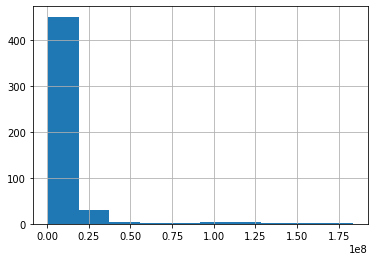

In [138]:
df_java_serialize["durationAnnotator"].hist()

<AxesSubplot:>

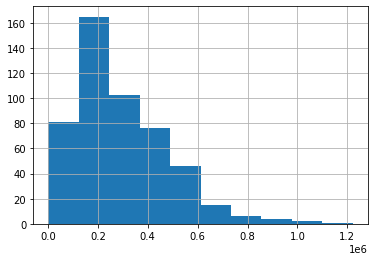

In [139]:
# Occurence by total document size
df_java_serialize["documentSize"].hist()

<AxesSubplot:>

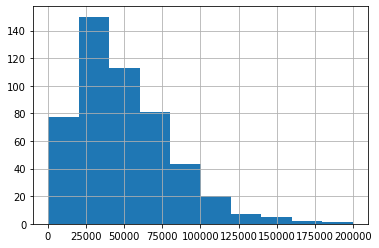

In [140]:
# Occurence by total number of annotations
df_java_serialize["totalAnnotations"].hist()

# Full document serialize performance
The following cells investigate the performance of the serializer and deserializer based on the document size and the total number of annotations

(499, 1)
Root mean squared error: 19657456.17


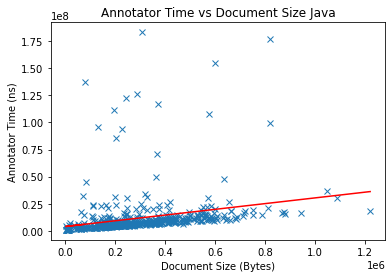

In [141]:
ax = df_java_serialize.plot(x="documentSize",y="durationAnnotator", style='x')
ax.set_xlabel("Document Size (Bytes)")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Document Size Java")

size = df_java_serialize["documentSize"].to_numpy().shape[0]
print(np.reshape(df_java_serialize["documentSize"].to_numpy(),(-1,1)).shape)
Y_java = np.reshape(df_java_serialize["durationAnnotator"].to_numpy(),(-1,1))
X_java = np.reshape(df_java_serialize["documentSize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_java_serialize["durationAnnotator"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java, Y_java))))

(499, 1)
Root mean squared error: 21608474.39


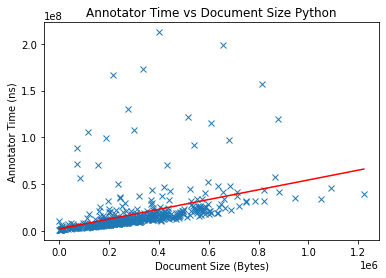

In [142]:
ax = df_python_serialize.plot(x="documentSize",y="durationAnnotator", style='x')
ax.set_xlabel("Document Size (Bytes)")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Document Size Python")

size = df_python_serialize["documentSize"].to_numpy().shape[0]
print(np.reshape(df_python_serialize["documentSize"].to_numpy(),(-1,1)).shape)
X_python = np.reshape(df_python_serialize["documentSize"].to_numpy(),(-1,1))
Y_python = np.reshape(df_python_serialize["durationAnnotator"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_python,df_python_serialize["durationAnnotator"].to_numpy())
Y_pred_python = reg.predict(X_python)
plt.plot(X_python, Y_pred_python, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_python, Y_python))))

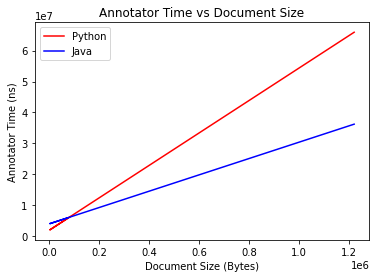

In [143]:
x = plt.plot(X_python, Y_pred_python, color='red')
plt.xlabel("Document Size (Bytes)")
plt.ylabel("Annotator Time (ns)")
plt.title("Annotator Time vs Document Size")

y = plt.plot(X_java, Y_pred_java, color='blue')
plt.legend(['Python', 'Java'])
plt.show()

(499, 1)
Root mean squared error: 19643901.34


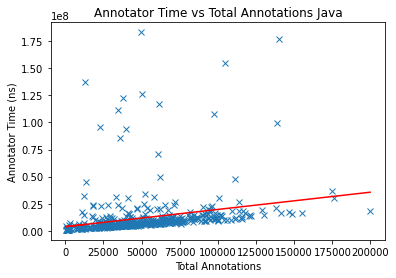

In [144]:
ax = df_java_serialize.plot(x="totalAnnotations",y="durationAnnotator", style='x')
ax.set_xlabel("Total Annotations")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Total Annotations Java")

size = df_java_serialize["totalAnnotations"].to_numpy().shape[0]
print(np.reshape(df_java_serialize["totalAnnotations"].to_numpy(),(-1,1)).shape)
X_java = np.reshape(df_java_serialize["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_java_serialize["durationAnnotator"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_java_serialize["durationAnnotator"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java, Y_java))))

plt.savefig(root+'java_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')
plt.savefig(root+'java_time_annotations'+experiment+'.png', dpi=300)

(499, 1)
(499, 1)
Root mean squared error linear: 21580138.73
Root mean squared error quadratic: 21569673.55


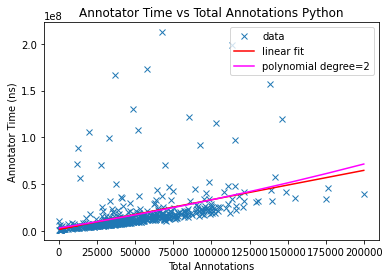

In [145]:
ax = df_python_serialize.plot(x="totalAnnotations",y="durationAnnotator", style='x')
ax.set_xlabel("Total Annotations")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Total Annotations Python")

size = df_python_serialize["totalAnnotations"].to_numpy().shape[0]
print(np.reshape(df_python_serialize["totalAnnotations"].to_numpy(),(-1,1)).shape)
X_python = np.reshape(df_python_serialize["totalAnnotations"].to_numpy(),(-1,1))
Y_python = np.reshape(df_python_serialize["durationAnnotator"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_python,df_python_serialize["durationAnnotator"].to_numpy())
Y_pred_python = reg.predict(X_python)

pol = PolynomialFeatures(degree=2)
X_ = pol.fit_transform(X_python)

polyreg = LinearRegression().fit(X_,df_python_serialize["durationAnnotator"].to_numpy())
Y_pred_pol = polyreg.predict(X_)
print(np.reshape(Y_pred_pol,(-1,1)).shape)
plt.plot(X_python, Y_pred_python, color='red')

idx = np.argsort(X_python[:,0])
x = X_python[idx]    

y = Y_python[idx]
#Non-linear predicted values
y_poly_pred= Y_pred_pol[idx]

plt.plot(x, y_poly_pred, color='magenta')
plt.legend(['data','linear fit','polynomial degree=2'])
print("Root mean squared error linear: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_python, Y_python))))
print("Root mean squared error quadratic: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(y_poly_pred, y))))
plt.savefig(root+'python_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'python_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')

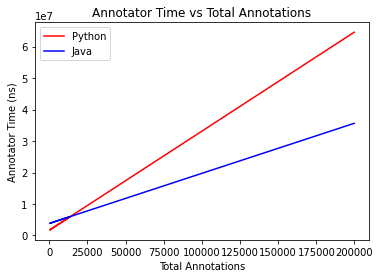

In [146]:
plt.plot(X_python, Y_pred_python, color='red')
plt.plot(X_java, Y_pred_java, color='blue')
plt.xlabel("Total Annotations")
plt.ylabel("Annotator Time (ns)")
plt.title("Annotator Time vs Total Annotations")
plt.legend(['Python', 'Java'])

plt.savefig(root+'java_python_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'java_python_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')
plt.show()

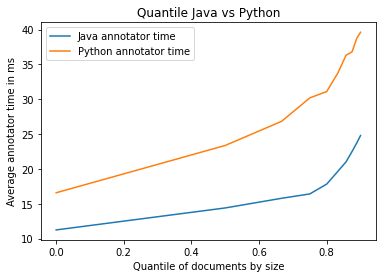

In [147]:
x = []
y = []


y_py = []
for i in range(10):
    df_java_i = df_java_serialize[df_java_serialize["totalAnnotations"]>df_java_serialize["totalAnnotations"].quantile(1-1/(i+1))]
    df_python_i = df_python_serialize[df_python_serialize["totalAnnotations"]>df_python_serialize["totalAnnotations"].quantile(1-1/(i+1))]
    x.append(1-1/(i+1))
    y.append(df_java_i["durationAnnotator"].mean()/(1024*1024))
    y_py.append(df_python_i["durationAnnotator"].mean()/(1024*1024))
plt.plot(x,y)
plt.plot(x,y_py)
plt.legend(["Java annotator time","Python annotator time"])
plt.xlabel("Quantile of documents by size")
plt.ylabel("Average annotator time in ms")
plt.title("Quantile Java vs Python")

plt.savefig(root+'quantile_java_python'+experiment+'.png', dpi=300)
plt.savefig(root+'quantile_java_python'+experiment+'.pgf', dpi=300, backend='pgf')

# Performance Analysis Token only
The previous analysis showed the serialization of the whole CAS document, this analysis shows the Case when only serializing a small part of the document!

In [148]:
df_python_token_serialize = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name="run_python_token"), con)
df_rust_lua_serialize = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name=names[3]), con)
df_java_token_serialize = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name="run_java_token"), con)


In [167]:
df_python_token_serialize

,pipelinename,componenthash,durationSerialize,durationDeserialize,durationAnnotator,durationMutexWait,durationComponentTotal,totalAnnotations,documentSize,serializedSize


In [149]:
print("Average annotator duration {name:.2f}ms python".format(name=df_python_token_serialize["durationAnnotator"].mean()/(1024*1024)))
print("Average annotator duration {name:.2f}ms rust:lua".format(name=df_rust_lua_serialize["durationAnnotator"].mean()/(1024*1024)))

print("Average annotator duration {name:.2f}ms java".format(name=df_java_token_serialize["durationAnnotator"].mean()/(1024*1024)))

Average annotator duration nanms python
Average annotator duration 7.40ms rust:lua
Average annotator duration nanms java


In [150]:
print("Max annotator duration {name:.2f}ms rust:lua".format(name=df_rust_lua_serialize["durationAnnotator"].max()/(1024*1024)))
print("Max annotator duration {name:.2f}ms python".format(name=df_python_token_serialize["durationAnnotator"].max()/(1024*1024)))
print("Max annotator duration {name:.2f}ms java".format(name=df_java_token_serialize["durationAnnotator"].max()/(1024*1024)))

Max annotator duration 151.88ms rust:lua
Max annotator duration nanms python
Max annotator duration nanms java


In [151]:
print("Mean number tokens {name:.2f} rust:lua".format(name=df_rust_lua_serialize["totalAnnotations"].mean()))
print("Mean number tokens {name:.2f} java".format(name=df_java_token_serialize["totalAnnotations"].mean()))
print("Mean number tokens {name:.2f} python".format(name=df_python_token_serialize["totalAnnotations"].mean()))

Mean number tokens 49771.72 rust:lua
Mean number tokens nan java
Mean number tokens nan python


(499, 1)
Root mean squared error: 14459607.23


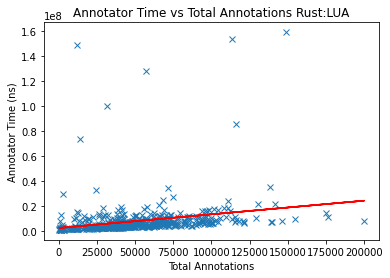

In [152]:
ax = df_rust_lua_serialize.plot(x="totalAnnotations",y="durationAnnotator", style='x')
ax.set_xlabel("Total Annotations")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Total Annotations Rust:LUA")

size = df_rust_lua_serialize["totalAnnotations"].to_numpy().shape[0]
print(np.reshape(df_rust_lua_serialize["totalAnnotations"].to_numpy(),(-1,1)).shape)
Y_rust_lua = np.reshape(df_rust_lua_serialize["durationAnnotator"].to_numpy(),(-1,1))
X_rust_lua = np.reshape(df_rust_lua_serialize["totalAnnotations"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_rust_lua,df_rust_lua_serialize["durationAnnotator"].to_numpy())
Y_pred_rust_lua = reg.predict(X_rust_lua)
plt.plot(X_rust_lua, Y_pred_rust_lua, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_rust_lua, Y_rust_lua))))

plt.savefig(root+'rust_lua_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'rust_lua_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')

In [153]:
ax = df_java_token_serialize.plot(x="totalAnnotations",y="durationAnnotator", style='x')
ax.set_xlabel("Total Annotations")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Total Annotations Java")

size = df_java_token_serialize["totalAnnotations"].to_numpy().shape[0]
print(np.reshape(df_java_token_serialize["totalAnnotations"].to_numpy(),(-1,1)).shape)
Y_java_token = np.reshape(df_java_token_serialize["durationAnnotator"].to_numpy(),(-1,1))
X_java_token = np.reshape(df_java_token_serialize["totalAnnotations"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java_token,df_java_token_serialize["durationAnnotator"].to_numpy())
Y_pred_java_token = reg.predict(X_java_token)
plt.plot(X_java_token, Y_pred_java_token, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java_token, Y_java_token))))
plt.savefig(root+'java_token_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'java_token_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')

TypeError: no numeric data to plot

In [154]:
ax = df_python_token_serialize.plot(x="totalAnnotations",y="durationAnnotator", style='x')
ax.set_xlabel("Total Annotations")
ax.set_ylabel("Annotator Time (ns)")
ax.get_legend().remove()
ax.set_title("Annotator Time vs Total Annotations Python")

size = df_python_token_serialize["totalAnnotations"].to_numpy().shape[0]
print(np.reshape(df_python_token_serialize["totalAnnotations"].to_numpy(),(-1,1)).shape)
X_python_token = np.reshape(df_python_token_serialize["totalAnnotations"].to_numpy(),(-1,1))
Y_python_token = np.reshape(df_python_token_serialize["durationAnnotator"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_python_token,df_python_token_serialize["durationAnnotator"].to_numpy())
Y_pred_python_token = reg.predict(X_python_token)
plt.plot(X_python_token, Y_pred_python_token, color='red')
print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_python_token, Y_python_token))))
plt.savefig(root+'python_token_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'python_token_time_annotations'+experiment+'.pgf', dpi=300, backend='pgf')

TypeError: no numeric data to plot

NameError: name 'X_java_token' is not defined

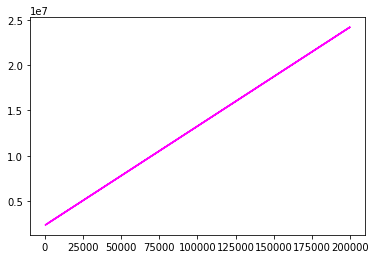

In [155]:
plt.plot(X_rust_lua, Y_pred_rust_lua, color='magenta')
plt.plot(X_java_token, Y_pred_java_token, color='red')
plt.plot(X_python_token, Y_pred_python_token, color='green')
plt.xlabel("Total Annotations")
plt.ylabel("Annotator Time (ns)")
plt.title("Annotator Time vs Total Annotations")
plt.legend(['Rust','Java XMI Serialize','Python dkpro cassis'])
plt.savefig(root+'rust_java_python_token_time_annotations'+experiment+'.png', dpi=300)
plt.savefig(root+'rust_java_python_token_time_annotations'+experiment+'.pgf', dpi=300,backend='pgf')
plt.show()

# Conclusion
Assuming a linear relationship between total annotations and serialization time it can be concluded that total annotations are a better predictor of serialization time.

# Amdahl's law
Based on the previous findings one can calculate the theoretically maximal speedup using docker swarm based on the assumption of amdahl's law.

![title](amdahl.png)

The following calculation is for the spacy annotator, since every annotator has a different tradeoff between work time and serialization time amdahl's law is different for every annotator.

In [156]:
df_spacy = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name=names[2]), con)

In [157]:
df_spacy.head()

,pipelinename,componenthash,durationSerialize,durationDeserialize,durationAnnotator,durationMutexWait,durationComponentTotal,totalAnnotations,documentSize,serializedSize
0,run_serde_echo_msgpack,1655345700,139488920,120271293,8862949,3552,268634393,2695,16872,33228
1,run_serde_echo_msgpack,1655345700,63373053,192700577,13308326,4380,269389907,27988,163428,400330
2,run_serde_echo_msgpack,1655345700,21997509,56861716,3992623,4612,82859919,17351,108538,242744
3,run_serde_echo_msgpack,1655345700,115206919,188904650,5768381,3516,309886207,41189,246760,620225
4,run_serde_echo_msgpack,1655345700,26811080,193751263,5198054,10191,225773965,42635,244633,631865


In [158]:
p = (df_spacy["durationAnnotator"]/df_spacy["durationComponentTotal"]).mean()

In [159]:
1/(1-(df_spacy["durationAnnotator"]/df_spacy["durationComponentTotal"]).mean())


1.0328351536203928

In [160]:
func = lambda x: (df_spacy["durationAnnotator"]/(df_spacy["durationComponentTotal"]-df_spacy["durationSerialize"]-df_spacy["durationDeserialize"]+df_spacy["durationSerialize"]/x+df_spacy["durationDeserialize"]/x)).mean()
def f(x,y):
    return 1/((1-func(y))+func(y)/x)

def array_map(x,y):
    return np.array([f(xi,y) for xi in x])

BrokenPipeError: [Errno 32] Broken pipe

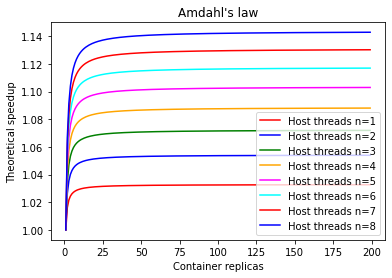

In [161]:
X_input = np.arange(1,200,1)
colors = ['red','blue','green','orange','magenta','cyan']
for i in range(8):
    Y_output = array_map(X_input,i+1)
    plt.plot(X_input, Y_output, color=colors[i%len(colors)])
plt.legend(['Host threads n=1','Host threads n=2','Host threads n=3','Host threads n=4','Host threads n=5','Host threads n=6','Host threads n=7','Host threads n=8'])
plt.title("Amdahl's law")
plt.ylabel("Theoretical speedup")
plt.xlabel("Container replicas")
plt.savefig(root+'amdahl_spacy_theory'+experiment+'.png', dpi=300)
plt.savefig(root+'amdahl_spacy_theory'+experiment+'.pgf', dpi=300, backend='pgf')

In [ ]:
X_input = np.arange(1,200,1)
Y_input = np.arange(1,20,1)
Z_output = np.array([[f(y,xi) for y in X_input] for xi in Y_input])
X_input,Y_input = np.meshgrid(X_input,Y_input)
print(Z_output.shape)
print(X_input.shape)
print(Y_input.shape)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( Y_input,X_input, Z_output, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Composer threads')
ax.set_ylabel('Container replicas')
ax.set_zlabel('Theoretical Speedup');
ax.set_title("SpaCy Amdahl's law")

plt.savefig(root+'amdahl_spacy_theory_3d'+experiment+'.png', dpi=300)
plt.savefig(root+'amdahl_spacy_theory_3d'+experiment+'.pgf', dpi=300, backend='pgf')

In [ ]:
X_input = np.arange(1,200,1)
Y_input = np.arange(1,20,1)
Z_output = np.array([[f(y,xi*2) for y in X_input] for xi in Y_input])
X_input,Y_input = np.meshgrid(X_input,Y_input)


fig = plt.figure()
gs1 = fig.add_gridspec(1, 2)

#ax = plt.axes(projection='3d')
ax = fig.add_subplot(gs1[0], projection='3d')
ax.plot_surface( Y_input,X_input, Z_output, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Host threads')
ax.set_ylabel('Container replicas')
ax.set_zlabel('Theoretical Speedup');
ax.set_title("3D Amdahl's law 2x faster Serialize/Deserialize")

ax = fig.add_subplot(gs1[1], projection='3d')
X_input = np.arange(1,200,1)
Y_input = np.arange(1,20,1)
Z_output = np.array([[f(y,xi*4) for y in X_input] for xi in Y_input])
X_input,Y_input = np.meshgrid(X_input,Y_input)



ax.plot_surface( Y_input,X_input, Z_output, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Composer threads')
ax.set_ylabel('Container replicas')
ax.set_zlabel('Theoretical Speedup');
ax.set_title("3D Amdahl's law 4x faster Serialize/Deserialize")
gs1.tight_layout(fig, rect=[None, None, 1.5, None])
plt.savefig(root+'amdahl_spacy_theory_3d_serialize_variation'+experiment+'.png', dpi=300, bbox_inches = 'tight')
plt.savefig(root+'amdahl_spacy_theory_3d_serialize_variation'+experiment+'.pgf', dpi=300, bbox_inches = 'tight', backen='pgf')

# Serialize Benchmark comparison

In [255]:
con = sqlite3.connect("serialization/serialization_gercorpa_500.db")
# Print all pipeline runs
cur = con.cursor()
names = []
for row in cur.execute('SELECT * FROM pipeline'):
    names.append(row[0])
print('Pipeline names: ',names)

Pipeline names:  ['run_serde_echo_binary', 'run_serde_echo_xmi', 'run_serde_echo_msgpack', 'run_serde_echo_json']


In [248]:
df_msgpack = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name='run_serde_echo_msgpack'), con)
df_xmi = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name='run_serde_echo_xmi'), con)
df_binary = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name='run_serde_echo_binary'), con)
df_json = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name='run_serde_echo_json'), con)

df_msgpack.head()

,pipelinename,componenthash,durationSerialize,durationDeserialize,durationAnnotator,durationMutexWait,durationComponentTotal,totalAnnotations,documentSize,serializedSize
0,run_serde_echo_msgpack,1655345700,378711646,251780808,25751949,3619,656257326,23407,136874,327902
1,run_serde_echo_msgpack,1655345700,156437112,190649624,20360660,6518,367458507,31255,180527,452098
2,run_serde_echo_msgpack,1655345700,45997132,157755029,5323711,27773,209107230,36417,211179,534310
3,run_serde_echo_msgpack,1655345700,153302709,194726900,7379065,3525,355415561,35071,203641,514098
4,run_serde_echo_msgpack,1655345700,85001267,128928991,5311977,2897,219247592,44712,266633,674845


In [249]:
print(df_msgpack["durationSerialize"].mean()/(1024*1024))
print(df_xmi["durationSerialize"].mean()/(1024*1024))
print(df_binary["durationSerialize"].mean()/(1024*1024))
print(df_json["durationSerialize"].mean()/(1024*1024))

70.92260562732656
165.21811254501344
52.78361358642578
255.41410128593444


In [250]:
print(df_msgpack["durationDeserialize"].mean()/(1024*1024))
print(df_xmi["durationDeserialize"].mean()/(1024*1024))
print(df_binary["durationDeserialize"].mean()/(1024*1024))
print(df_json["durationDeserialize"].mean()/(1024*1024))

159.72239885022563
208.60979385375975
28.60124093055725
1047.8352767086028


In [251]:
print(df_msgpack["serializedSize"].mean())
print(df_xmi["serializedSize"].mean())
print(df_binary["serializedSize"].mean())
print(df_json["serializedSize"].mean())

784592.1075268817
4842342.62
2683882.72
1213445.86


Root mean squared error: 117199967.44


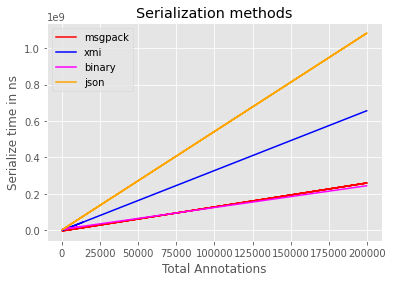

In [231]:
size = df_msgpack["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_msgpack["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_msgpack["durationSerialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_msgpack["durationSerialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
#
plt.plot(X_java, Y_pred_java, color='red')


size = df_xmi["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_xmi["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_xmi["durationSerialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_xmi["durationSerialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
#df_xmi.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='blue', alpha=0.2)
plt.plot(X_java, Y_pred_java, color='blue')

size = df_binary["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_binary["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_binary["durationSerialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_binary["durationSerialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
#df_binary.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='magenta')
plt.plot(X_java, Y_pred_java, color='magenta')

size = df_json["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_json["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_json["durationSerialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_json["durationSerialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
#df_json.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='orange')
plt.plot(X_java, Y_pred_java, color='orange')

plt.legend(['msgpack','xmi','binary','json'])
plt.ylabel('Serialize time in ns')
plt.xlabel('Total Annotations')
plt.title('Serialization methods')

print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java, Y_java))))

<AxesSubplot:xlabel='totalAnnotations'>

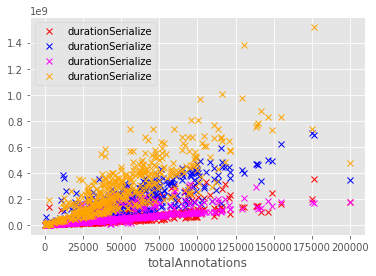

In [232]:
df_msgpack.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='red')
df_xmi.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='blue')
df_binary.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='magenta')
df_json.plot(x="totalAnnotations",y="durationSerialize", style='x', ax=plt.gca(), color='orange')

Root mean squared error: 523637491.33


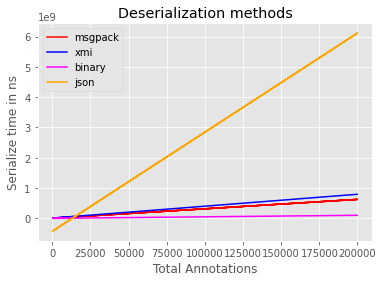

In [233]:
size = df_msgpack["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_msgpack["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_msgpack["durationDeserialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_msgpack["durationDeserialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='red')


size = df_xmi["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_xmi["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_xmi["durationDeserialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_xmi["durationDeserialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='blue')

size = df_binary["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_binary["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_binary["durationDeserialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_binary["durationDeserialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='magenta')

size = df_json["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_json["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_json["durationDeserialize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_json["durationDeserialize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='orange')

plt.legend(['msgpack','xmi','binary','json'])
plt.ylabel('Serialize time in ns')
plt.xlabel('Total Annotations')
plt.title('Deserialization methods')

print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java, Y_java))))

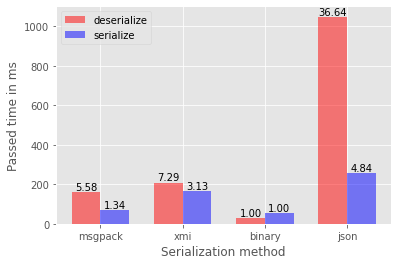

In [256]:
plt.style.use('ggplot')
a = df_msgpack["durationDeserialize"].mean()/(1024*1024)
b = df_xmi["durationDeserialize"].mean()/(1024*1024)
c = df_binary["durationDeserialize"].mean()/(1024*1024)
d = df_json["durationDeserialize"].mean()/(1024*1024)
ind = np.arange(4)
bar = plt.bar(ind,[a,b,c,d],0.35, align='center', alpha=0.5, color='r')
vals = [a,b,c,d]
for (i,rect) in enumerate(bar):
    height = rect.get_height()
    val = vals[i]/c
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{val:.2f}', ha='center', va='bottom')
    
a = df_msgpack["durationSerialize"].mean()/(1024*1024)
b = df_xmi["durationSerialize"].mean()/(1024*1024)
c = df_binary["durationSerialize"].mean()/(1024*1024)
d = df_json["durationSerialize"].mean()/(1024*1024)
bar = plt.bar(ind+0.35,[a,b,c,d],0.35, align='center', alpha=0.5, color='b')
vals = [a,b,c,d]
for (i,rect) in enumerate(bar):
    height = rect.get_height()
    val = vals[i]/c
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{val:.2f}', ha='center', va='bottom')
    
plt.xticks(ind + 0.35 / 2, ('msgpack', 'xmi', 'binary', 'json'))
plt.legend(['deserialize','serialize'])
plt.ylabel('Passed time in ms')
plt.xlabel('Serialization method')
plt.savefig(root+'serialize_deserialize_performance'+experiment+'.png', dpi=300, bbox_inches = 'tight')
#plt.savefig(root+'serialize_deserialize_performance'+experiment+'.pgf', dpi=300, bbox_inches = 'tight', backend='pgf')

Root mean squared error: 14888.09


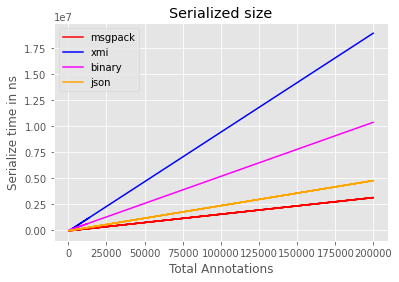

In [235]:
size = df_msgpack["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_msgpack["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_msgpack["serializedSize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_msgpack["serializedSize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='red')


size = df_xmi["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_xmi["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_xmi["serializedSize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_xmi["serializedSize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='blue')

size = df_binary["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_binary["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_binary["serializedSize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_binary["serializedSize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='magenta')

size = df_json["totalAnnotations"].to_numpy().shape[0]
X_java = np.reshape(df_json["totalAnnotations"].to_numpy(),(-1,1))
Y_java = np.reshape(df_json["serializedSize"].to_numpy(),(-1,1))
reg = LinearRegression().fit(X_java,df_json["serializedSize"].to_numpy())
Y_pred_java = reg.predict(X_java)
plt.plot(X_java, Y_pred_java, color='orange')

plt.legend(['msgpack','xmi','binary','json'])
plt.ylabel('Serialize time in ns')
plt.xlabel('Total Annotations')
plt.title('Serialized size')

print("Root mean squared error: {error:.2f}".format(error=np.sqrt(sklearn.metrics.mean_squared_error(Y_pred_java, Y_java))))

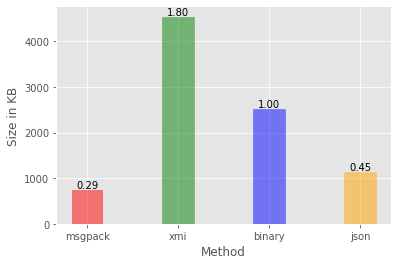

In [236]:
plt.style.use('ggplot')
a = df_msgpack["serializedSize"].mean()/(1024)
b = df_xmi["serializedSize"].mean()/(1024)
c = df_binary["serializedSize"].mean()/(1024)
d = df_json["serializedSize"].mean()/(1024)
bar = plt.bar(['msgpack','xmi','binary','json'],[a,b,c,d],0.35, align='center', alpha=0.5, color='r')
vals = [a,b,c,d]
bar[1].set_color('g')
bar[2].set_color('b')
bar[3].set_color('orange')
for (i,rect) in enumerate(bar):
    height = rect.get_height()
    val = vals[i]/c
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{val:.2f}', ha='center', va='bottom')
plt.ylabel("Size in KB")
plt.xlabel("Method")
plt.savefig(root+'serialization_size'+experiment+'.png', dpi=300, bbox_inches = 'tight')
#plt.savefig(root+'serialization_size'+experiment+'.pgf', dpi=300, bbox_inches = 'tight',backend='pgf')

In [222]:
con = sqlite3.connect('../serialization_gercorpa.db')

In [223]:
df_an_java = pd.read_sql_query("SELECT * from pipeline_document_perf WHERE pipelinename=\"{name}\"".format(name="run_serde_echo_binary"), con)

In [224]:
df_an_java.head()

,pipelinename,componenthash,durationSerialize,durationDeserialize,durationAnnotator,durationMutexWait,durationComponentTotal,totalAnnotations,documentSize,serializedSize


In [ ]:
df_wait = pd.read_sql_query("SELECT * from pipeline_document;", con)

In [ ]:
df_wait["waitTime"].min()

In [ ]:
df_wait["waitTime"].mean()

In [ ]:
df_an_java["durationComponentTotal"].mean()

In [ ]:
df_wait.head()